# Prophet template light con incertezza

In [29]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

### Scelgo una colonna e imposto il dataframe come vuole prophet

In [30]:
df = pd.read_excel('db_assunzioni.xlsx') #INSERIRE DATASET DA USARE
df.rename(columns={df.columns[0]:'ds'},inplace=True)
column = 'F41_L' #INSERIRE COLONNA SU CUI FARE L'ANALISI
df_ready = df[['ds',column]]
df_ready.rename(columns={column:'y'},inplace=True)
#df_ready.head()

/home/davide/.local/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [31]:
first_1gen = 0
for d in df_ready['ds']:
    if d.day == 1 and d.month==1:
        break
    else:
        first_1gen += 1
first_1gen

0

In [32]:
def shitf_date_n_months(d,n):
    y = int(n/12) 
    m = d.month - n%12
    if m <=0:
        m = 12 + m
        y -= 1
    return pd.to_datetime(str(d.year + y)+'-'+str(m)+'-'+str(1))

In [33]:
#df_ready.set_index('ds').plot(figsize=(18,6))
#plt.title(column)

## PARAMETRIZZAZIONE PROPHET

### PARAMETRI TREND PROPHET <br/>

1. **intervallo**: intervallo della serie in cui si cercano i change points e si è sensibili al trend <br/>
    Es. intervallo=0.8 -> i changepoints il trend verranno considerati dall'inizio fino al 80% della lunghezza della serie<br/>
    VALORE DEFAULT: 0.8<br/>
    PRO: aumento precisione nel seguire il trend a fine serie<br/>
    CONTRO: pericolo overfitting<br/>
    <br/>
2. **n_punti_cambio**: numero di change points rilevabili<br/>
    VALORE DEFAULT: 25<br/>
    PRO: aumento dettaglio, aumento fitting sul trend<br/>
    CONTRO: troppi punti anche insignificanti, overfitting sul trend<br/><br/>
    <br/>
3. **sensibilita_cambio_trend**: sensibilita' ai cambi di trend<br/>
    VALORE DEFAULT: 0.05<br/>
    PRO: aumento precisione nel seguire il trend<br/>
    CONTRO: pericolo overfitting<br/><br/>


In [34]:
intervallo=0.9
n_punti_cambio=50
sensibilita_cambio_trend=0.3

### PARAMETRI STAGIONALITÀ PROPHET<br/>

1. **sensibilita_cambio_stagionalita**: sensibilità ai cambi di stagionalità<br/>
    VALORE DEFAULT: 10<br/>
    PRO: aumento precisione nel seguire stagionalità<br/>
    CONTRO: pericolo overfitting<br/>
    <br/>
2. **precisione stagionalita**:  precisione curva stagionalità<br/>
    aumentando questo parametro la curva della stagionalità viene modellizzata in modo più complesso <br/>
    VALORE DEFAULT: 20<br/>
    'auto' decide automaticamente <br/>
    'True' rileva la stagionalità annuale <br/>
    'False' disabilita il rilevamento della stagionalità (da usare quando stagionalità molto bassa) <br/>
    VALORE DEFAULT: 'auto'<br/>
    
3. **modalita_stagionalita**: possibili modalità: 'additive' o 'multiplivative'<br/>
    additive: l'effetto della stagionalità si somma alla serie(usare con stagionalità stabile)<br/>
    multiplivative: l'effetto della stagionalità si moltiplica alla serie(usare con stagionalità variabile)<br/>
    VALORE DEFAULT:  'additive'<br/>

In [35]:
sensibilita_cambio_stagionalita = 11.5
precisione_stagionalita = 13
modalita_stagionalita ='additive' 

### PARAMETRI INDECISIONE PROPHET (la documentazione ufficiale sconsiglia CALDAMENTE di non cambiare questi parametri)<br/>

1. **campioni_per_calcolo_incertezza**: numero campioni usati per il calcolo dell'incertezza<br/>
    Mettendo un valore diverso da zero prophet cambia faccia: cambia il modello statistico, viene introdotta l'incertezza anche sulle componenti singole: trend e stagionalità.<br/>
    Quando questo parametro vale zero viene calcolata solo l'incertezza in modo "statico" sull'andamento.<br/>
    Se impostato diverso da default impostare un valore di almeno 21 altrimenti l'algoritmo sull'incertezza non funziona a dovere e i risultati sono strani.<br/>
    VALORE DEFAULT: 0<br/><br/>
    **#WARNING ALTA TENSIONE# QUESTO PARAMETRO INTRODUCE DINAMICHE DIVERSE NEL MODELLO, INOLTRE:**<br/>
    **- PUò CAPITARE CHE IL NUMERO MASSIMO DI CHANGE POINTS DIVENTA PRATICAMENTE IL VALORE DI CHANGE POINTS EFFETTIVAMENTE PRESI: PERICOLO OVERFITTING**<br/>
    **- Abilitare questo parametro aumenta notevoltemte i tempi di computazione**<br/><br/>

2. **intervallo_incertezza**: incertezza visualizzata<br/>
    Se per esempio viene impostato a 0.8 viene visualizzata(nell'area azzurrina) la distribuzione dell'80% dei valori predetti più probabili <br/>
    Prophet internamente per ogni valore della serie non fa un'unica previsione ma una distribuzione<br/>
    Sempre nel caso di 0.8, sarebbe come dire a prophet: "Mi fai vedere dove stanno le tue previsioni tolte quelle meno probabili(20%) ?" <br/>
    VALORE DEFAULT: 0.8<br/><br/>

Con questi parametri impostati da me come sotto, spingo volutamente il modello ai sui limiti, "rilassandolo" al massimo ma con il solo scopo di avere informazioni mirate sul trend e sulla stagionalità


In [36]:
campioni_per_calcolo_incertezza=0
intervallo_incertezza=0.80

### Numero di mesi da predire

In [37]:
mesi = 12

---

## ANALISI 

In [38]:
%%capture
m2 = Prophet( 
                changepoint_range=intervallo,
                n_changepoints=n_punti_cambio,
                changepoint_prior_scale=sensibilita_cambio_trend,
                seasonality_prior_scale=sensibilita_cambio_stagionalita,
                seasonality_mode = modalita_stagionalita,
                yearly_seasonality=precisione_stagionalita,
                mcmc_samples=campioni_per_calcolo_incertezza,
                interval_width=intervallo_incertezza,
                uncertainty_samples=2000,
                )
m2.fit(df_ready);
future2 = m2.make_future_dataframe(periods=mesi,freq = 'MS')
forecast2 = m2.predict(future2);

Initial log joint probability = -4.33329
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       273.264     0.0151656       28.8378       0.873      0.2027      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       274.261   0.000620011       20.5439           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       274.341    0.00091837       39.0003   4.678e-05       0.001      294  LS failed, Hessian reset 
     299       274.395   1.90319e-06       18.3022           1           1      405   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345       274.395   2.93082e-06       14.0779   1.589e-07       0.001      498  LS failed, Hessian reset 
     358       274.395   8.86169e-08       15.2406      0.2003           1      515   
Optimization terminat

### COMPONENTI

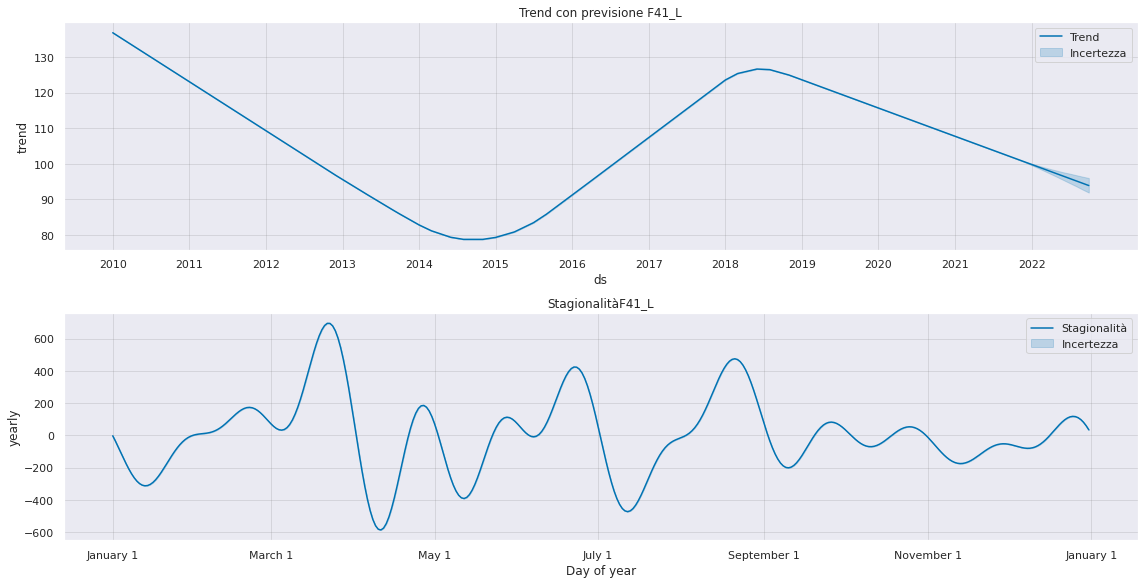

In [39]:
fig3 = m2.plot_components(forecast2[:],figsize=(16,8))
plt.title('Stagionalità'+ column)
plt.legend(['Stagionalità','Incertezza'])
plt.tight_layout()
fig3.axes[0].set_title('Trend con previsione ' + column)
fig3.axes[0].legend(['Trend','Incertezza'])
fig3.axes[0].set_xticks(ticks=[data for data in forecast2['ds'][first_1gen::12]],labels=[data.year for data in forecast2['ds'][first_1gen::12]]);

### GRAFICO DEI PUNTI DI CAMBIO DI TREND

In [40]:
#date changepoints
df = pd.DataFrame()
df['Change points '+column] = m2.changepoints
df.to_excel('Change points '+column+'.xlsx')

In [41]:
#numero di changepoints
print('Numero di change points: '+ str(len(m2.changepoints)))

Numero di change points: 50


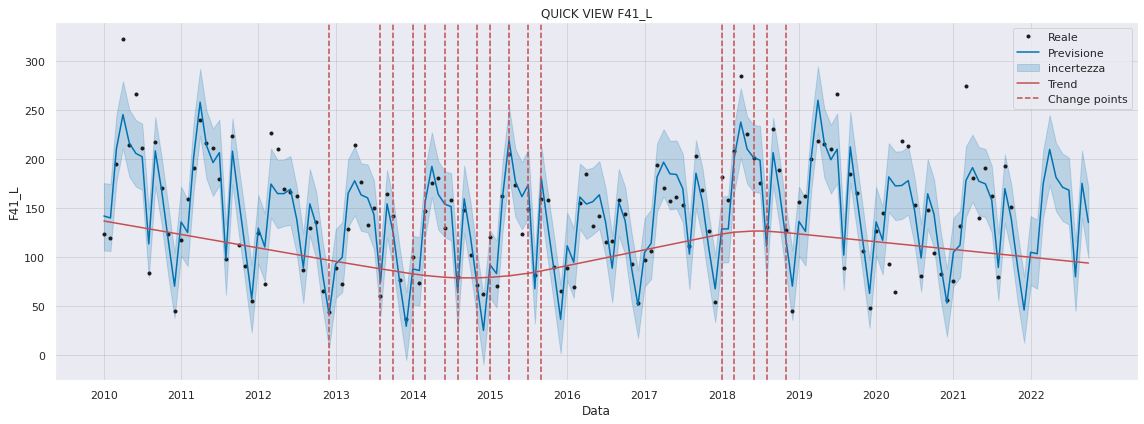

In [42]:
fig = m2.plot(forecast2[:],figsize=(16,6))
add_changepoints_to_plot(fig.gca(), m2, forecast2)
plt.legend(['Reale','Previsione','incertezza','Trend','Change points'])

plt.xticks(ticks=[data for data in forecast2['ds'][first_1gen::12]],labels=[data.year for data in forecast2['ds'][first_1gen::12]])
plt.xlabel('Data')
plt.ylabel(column)
plt.title('QUICK VIEW '+column)
plt.tight_layout()
plt.show()

---

### Analisi incertezza (se viene abilitata l'incertezza sulle componenti)

In [43]:
df_output = pd.DataFrame()
df_output['Incertezza assoluta trend'] = forecast2['trend_upper']-forecast2['trend_lower']
df_output['Variazione percentuale incertezza assoluta trend'] = (forecast2['trend_upper']-forecast2['trend_lower']).pct_change()*100
df_output['Incertezza assoluta stagionalità'] = forecast2['yearly_upper']-forecast2['yearly_lower']
df_output['Incertezza assoluta totale'] = forecast2['yhat_upper']-forecast2['yhat_lower']
df_output.index = forecast2['ds']

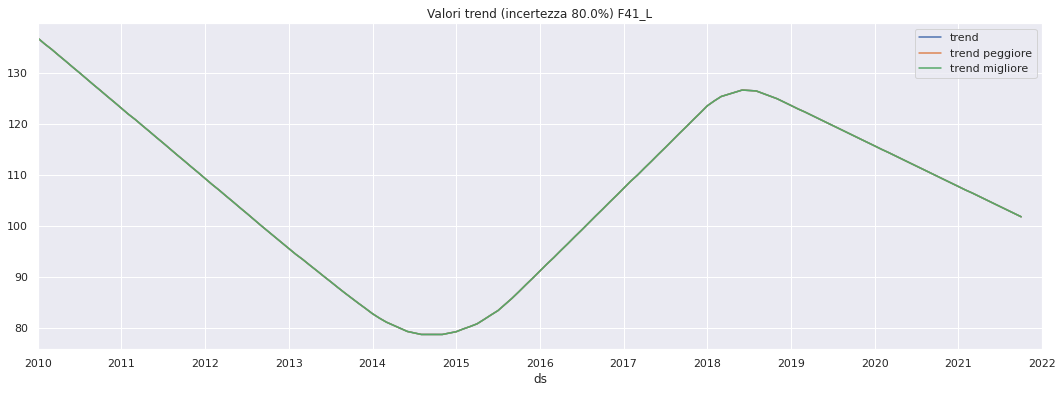

In [44]:
fig = forecast2[['ds','trend','trend_lower','trend_upper']][:-mesi].set_index('ds').plot(figsize=(18,6))
plt.xticks(ticks=[data for data in forecast2['ds'][first_1gen::12]],labels=[data.year for data in forecast2['ds'][first_1gen::12]])
plt.title('Valori trend (incertezza '+str(intervallo_incertezza*100)+'%) '+column)
plt.legend(['trend','trend peggiore','trend migliore'])

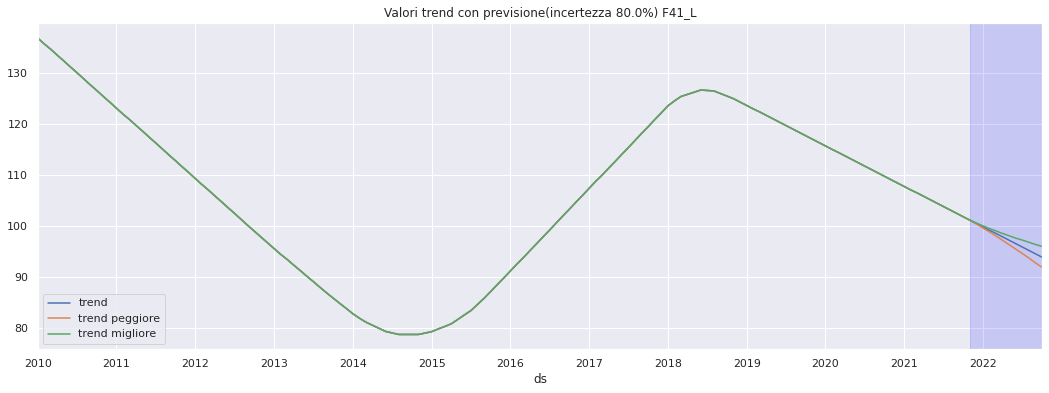

In [45]:
fig = forecast2[['ds','trend','trend_lower','trend_upper']][:].set_index('ds').plot(figsize=(18,6))
plt.xticks(ticks=[data for data in forecast2['ds'][first_1gen::12]],labels=[data.year for data in forecast2['ds'][first_1gen::12]])
plt.title('Valori trend con previsione(incertezza '+str(intervallo_incertezza*100)+'%) '+column)
plt.legend(['trend','trend peggiore','trend migliore'])
fig.axes.axvspan(str(forecast2['ds'][-mesi:-mesi+1][forecast2['ds'][-mesi:-mesi+1].index[0]])[:10],str(forecast2['ds'][-1:][forecast2['ds'][-1:].index[0]])[:10],color='Blue',alpha=0.15)

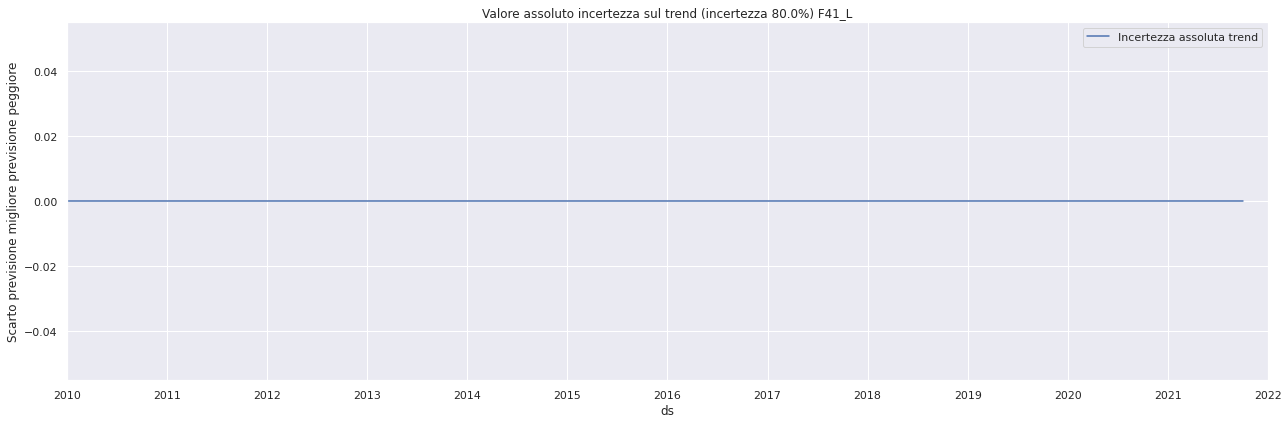

In [46]:
df_output['Incertezza assoluta trend'][:-mesi].plot(figsize=(18,6))
plt.xticks(ticks=[data for data in forecast2['ds'][first_1gen::12]],labels=[data.year for data in forecast2['ds'][first_1gen::12]])
plt.ylabel('Scarto previsione migliore previsione peggiore')
plt.title('Valore assoluto incertezza sul trend (incertezza '+str(intervallo_incertezza*100)+'%) '+column)
plt.legend()
plt.tight_layout()


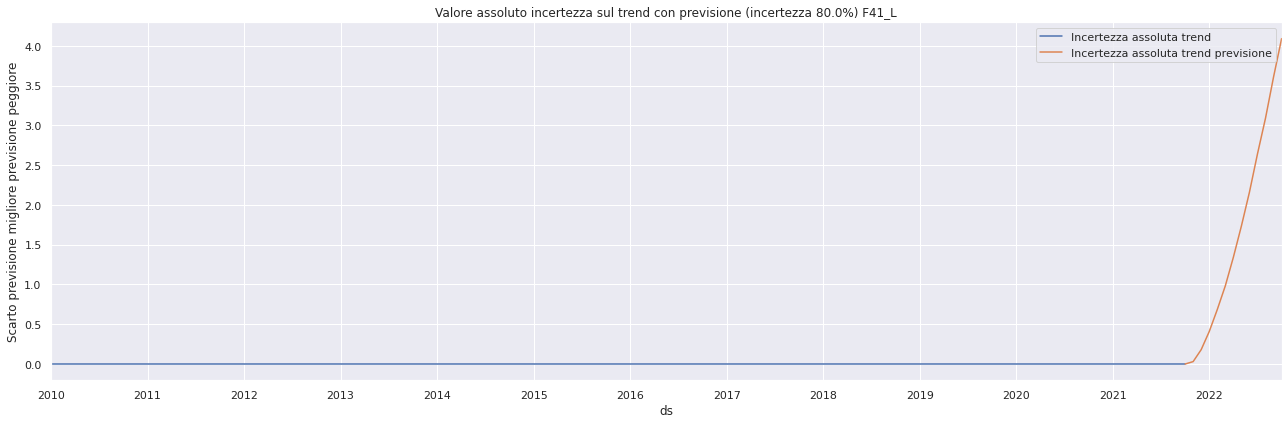

In [47]:
df_output['Incertezza assoluta trend'][:-mesi].plot(figsize=(18,6))
df_output['Incertezza assoluta trend'][-mesi-1:].plot(figsize=(18,6))
plt.xticks(ticks=[data for data in forecast2['ds'][first_1gen::12]],labels=[data.year for data in forecast2['ds'][first_1gen::12]])
plt.ylabel('Scarto previsione migliore previsione peggiore')
plt.title('Valore assoluto incertezza sul trend con previsione (incertezza '+str(intervallo_incertezza*100)+'%) '+column)
plt.legend(['Incertezza assoluta trend','Incertezza assoluta trend previsione'])
plt.tight_layout()

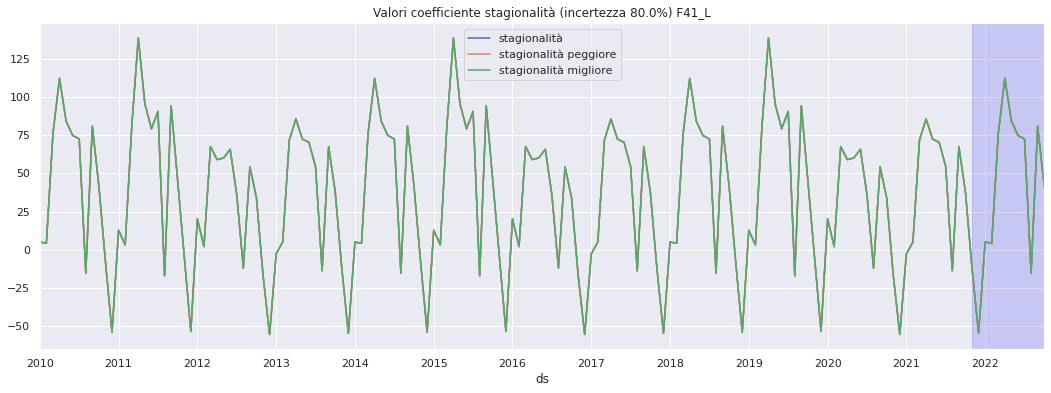

In [48]:
fig = forecast2[['ds','yearly','yearly_lower','yearly_upper']].set_index('ds').plot(figsize=(18,6))
plt.xticks(ticks=[data for data in forecast2['ds'][first_1gen::12]],labels=[data.year for data in forecast2['ds'][first_1gen::12]])
plt.title('Valori coefficiente stagionalità (incertezza '+str(intervallo_incertezza*100)+'%) '+column)
plt.legend(['stagionalità','stagionalità peggiore','stagionalità migliore'])
fig.axes.axvspan(str(forecast2['ds'][-mesi:-mesi+1][forecast2['ds'][-mesi:-mesi+1].index[0]])[:10],str(forecast2['ds'][-1:][forecast2['ds'][-1:].index[0]])[:10],color='Blue',alpha=0.15)

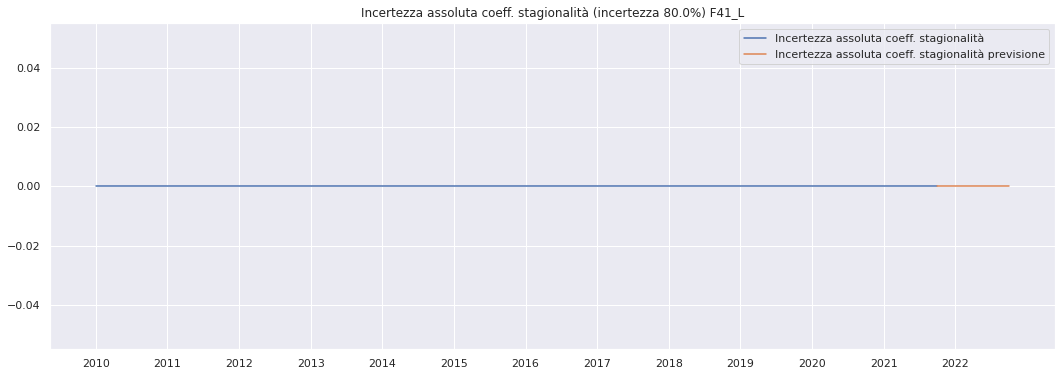

In [49]:
plt.figure(figsize=(18,6))
plt.plot(forecast2[['ds','yearly_upper']][:-mesi].set_index('ds')['yearly_upper']-forecast2[['ds','yearly_lower']].set_index('ds')['yearly_lower'])
plt.plot(forecast2[['ds','yearly_upper']][-mesi-1:].set_index('ds')['yearly_upper']-forecast2[['ds','yearly_lower']].set_index('ds')['yearly_lower'])
plt.xticks(ticks=[data for data in forecast2['ds'][first_1gen::12]],labels=[data.year for data in forecast2['ds'][first_1gen::12]])
plt.title('Incertezza assoluta coeff. stagionalità (incertezza '+str(intervallo_incertezza*100)+'%) '+column)
plt.legend(['Incertezza assoluta coeff. stagionalità','Incertezza assoluta coeff. stagionalità previsione'])
plt.show()

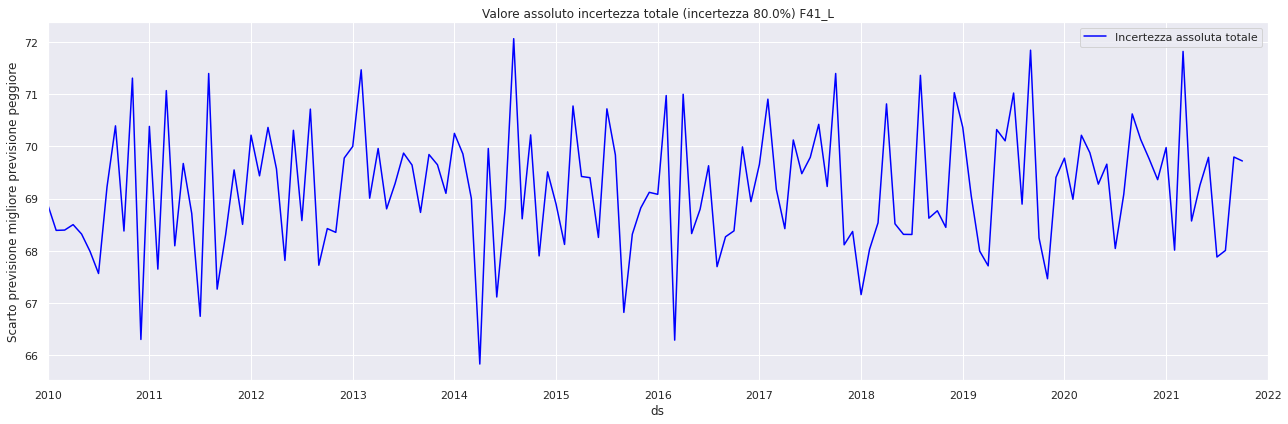

In [50]:
df_output['Incertezza assoluta totale'][:-mesi].plot(figsize=(18,6),color='blue')
plt.xticks(ticks=[data for data in forecast2['ds'][first_1gen::12]],labels=[data.year for data in forecast2['ds'][first_1gen::12]])
plt.ylabel('Scarto previsione migliore previsione peggiore')
plt.title('Valore assoluto incertezza totale (incertezza '+str(intervallo_incertezza*100)+'%) '+column)
plt.legend()
plt.tight_layout()

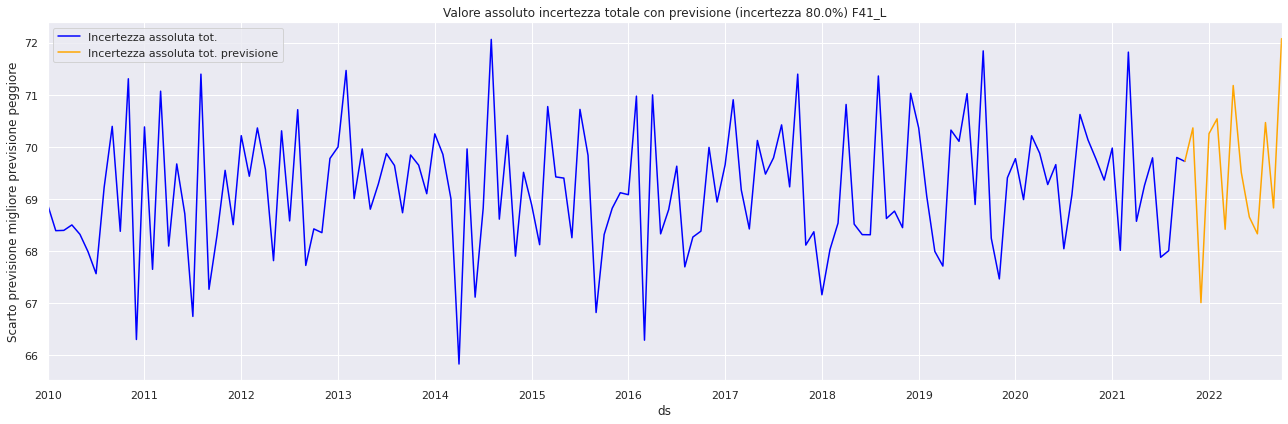

In [51]:
df_output['Incertezza assoluta totale'][:-mesi].plot(figsize=(18,6),color='blue')
df_output['Incertezza assoluta totale'][-mesi-1:].plot(figsize=(18,6),color='orange')
plt.xticks(ticks=[data for data in forecast2['ds'][first_1gen::12]],labels=[data.year for data in forecast2['ds'][first_1gen::12]])
plt.ylabel('Scarto previsione migliore previsione peggiore')
plt.title('Valore assoluto incertezza totale con previsione (incertezza '+str(intervallo_incertezza*100)+'%) '+column)
plt.legend(['Incertezza assoluta tot.','Incertezza assoluta tot. previsione'])
plt.tight_layout()